In [1]:
from model import NextFramePredictor, get_next_frame_dataloader
from performance_plots import performance_boxplots

import torch
import torch.nn as nn
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.style.use("default")

import config

In [3]:
def test_performance(model, data_loader, criterion):
    loss_list = []
    model.eval()
    with torch.no_grad():
        for input, target in data_loader:
            output = model(input)
            loss = criterion(output.flatten(), target.flatten())
            loss_list.append(loss.item())
    return loss_list


def initialize_model(SEQ2LATENT_MODEL_PATH, LATENT2NEXTFRAME_MODEL_PATH, device):
    model = NextFramePredictor(num_channels=1, num_kernels=64,
                               kernel_size=(3, 3), padding=(1, 1), cell_type="RNN").to(device)
    if SEQ2LATENT_MODEL_PATH != "None":
        model.load_models(SEQ2LATENT_MODEL_PATH, LATENT2NEXTFRAME_MODEL_PATH, device)

    criterion = nn.MSELoss(reduction='sum')

    return model, criterion


def get_epoch_losses(parent_dir, model_dirs, epoch, data_loader, precomputed_loss=None, fold_nr=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss = {} if precomputed_loss is None else precomputed_loss
    model_name = "best_model" if epoch == "best" else "model"

    for current_model_dir in model_dirs:
        print(f"Calculating loss for {current_model_dir}")
        if current_model_dir not in loss.keys():
            loss[current_model_dir] = []
        for replicate_dir in tqdm(os.listdir(f'{parent_dir}/{current_model_dir}')):
            if 'LM' not in replicate_dir:
                continue
            if fold_nr is not None and not replicate_dir.endswith(f"_{fold_nr}"):
                continue

            if epoch == "best":
                for file in os.listdir(f'{parent_dir}/{current_model_dir}/{replicate_dir}'):
                    if 'best' in file:
                        epoch_nr = file.split('_')[-2]
            else:
                epoch_nr = epoch

            SEQ2LATENT_MODEL_PATH = f'{parent_dir}/{current_model_dir}/{replicate_dir}/{model_name}_epoch_{epoch_nr}_seq2latent.pth'
            LATENT2NEXTFRAME_MODEL_PATH = f'{parent_dir}/{current_model_dir}/{replicate_dir}/{model_name}_epoch_{epoch_nr}_latent2nextframe.pth'

            model, criterion = initialize_model(SEQ2LATENT_MODEL_PATH, LATENT2NEXTFRAME_MODEL_PATH, device)
            loss_list = test_performance(model, data_loader, criterion)
            loss[current_model_dir].extend(loss_list)

    return loss

In [4]:
RNN_parent_dir = f'{config.project_dir}/Output/NI_maze/RNN'
RNN_model_dirs = ['Pretrained_Directional', 'Pretrained_Godfrey', 'No_Pretraining', 'Shuffled_Directional']
RNN_model_names = ['DirectedProp', 'NotDirectedProp', 'NotPretrained', 'DirectedProp Shuffled']
RNN_model_designs = [{'color': '#0065bd', 'marker': 'o'},
                     {'color': '#d6a319', 'marker': 'x'},
                     {'color': '#4cc997', 'marker': 'v'},
                     {'color': '#cc323f', 'marker': '.'}]

# Validation Datasets (5 folds)

In [6]:
dataset_path = f"{config.project_dir}/NI_maze"
palette = {model: design['color'] for model, design in zip(RNN_model_dirs, RNN_model_designs)}

In [6]:
validation_loss = {}
for fold in [1,2,3,4,5]:
    val_loader = get_next_frame_dataloader(f"{dataset_path}/fold_{fold}/validation", batch_size=1)
    validation_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 0, val_loader, precomputed_loss=validation_loss, fold_nr=fold)

pickle.dump(validation_loss, open(f'revisions_data/epoch_0_validation_loss.pkl', 'wb'))

Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:32<00:00,  5.35s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:30<00:00,  6.17s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:29<00:00,  4.86s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:30<00:00,  6.06s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:28<00:00,  4.81s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:29<00:00,  4.84s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.97s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:27<00:00,  4.55s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.86s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:29<00:00,  4.84s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:29<00:00,  4.88s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.91s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:28<00:00,  4.82s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:29<00:00,  4.89s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.86s/it]


Pretrained_Directional vs Pretrained_Godfrey: 4.7967996513853136e-24
Pretrained_Directional vs No_Pretraining: 0.0
Pretrained_Directional vs Shuffled_Directional: 1.8286901988027822e-103
Pretrained_Godfrey vs No_Pretraining: 1.7505519023878357e-270
Pretrained_Godfrey vs Shuffled_Directional: 3.1553847857884345e-70
No_Pretraining vs Shuffled_Directional: 6.566063803492471e-105


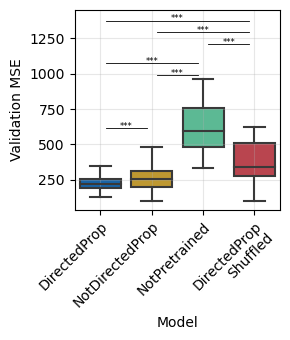

In [10]:
validation_loss = pickle.load(open(f'revisions_data/epoch_0_validation_loss.pkl', 'rb'))
performance_boxplots(validation_loss,
                     RNN_model_dirs,
                     RNN_model_names,
                     palette,
                     "figures_revisions/Figure_2/boxplots",
                     epoch=0,
                     set='Validation',
                     ylim=1450,
                     y_offset_fixed=53,
                     y_offset_scale=0.07)

In [8]:
validation_loss = {}
for fold in [1,2,3,4,5]:
    val_loader = get_next_frame_dataloader(f"{dataset_path}/fold_{fold}/validation", batch_size=1)
    validation_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 1, val_loader, precomputed_loss=validation_loss, fold_nr=fold)

pickle.dump(validation_loss, open(f'revisions_data/epoch_1_validation_loss.pkl', 'wb'))

Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:29<00:00,  4.85s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:27<00:00,  4.59s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:28<00:00,  4.80s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:29<00:00,  4.85s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.73s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:29<00:00,  4.91s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.91s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:29<00:00,  4.88s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.68s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:29<00:00,  4.98s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:27<00:00,  4.57s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:27<00:00,  5.45s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:28<00:00,  4.82s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


Pretrained_Directional vs Pretrained_Godfrey: 5.512706649265454e-57
Pretrained_Directional vs No_Pretraining: 1.49683808006e-313
Pretrained_Directional vs Shuffled_Directional: 5.328668573340261e-280
Pretrained_Godfrey vs No_Pretraining: 3.244762138122901e-266
Pretrained_Godfrey vs Shuffled_Directional: 7.923362808532805e-199
No_Pretraining vs Shuffled_Directional: 5.175660932662813e-42


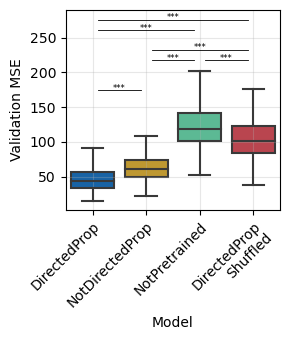

In [30]:
validation_loss = pickle.load(open(f'revisions_data/epoch_1_validation_loss.pkl', 'rb'))
performance_boxplots(validation_loss,
                     RNN_model_dirs,
                     RNN_model_names,
                     palette,
                     "figures_revisions/Figure_2/boxplots",
                     epoch=1,
                     set='Validation',
                     ylim=290,
                     y_offset_fixed=65,
                     y_offset_scale=0.18)

In [10]:
validation_loss = {}
for fold in [1,2,3,4,5]:
    val_loader = get_next_frame_dataloader(f"{dataset_path}/fold_{fold}/validation", batch_size=1)
    validation_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, "best", val_loader, precomputed_loss=validation_loss, fold_nr=fold)

pickle.dump(validation_loss, open(f'revisions_data/epoch_best_validation_loss.pkl', 'wb'))

Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:28<00:00,  4.81s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:29<00:00,  4.85s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:29<00:00,  4.85s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.68s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:28<00:00,  4.77s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.94s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:27<00:00,  5.48s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:27<00:00,  4.64s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:28<00:00,  5.66s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:29<00:00,  4.88s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:27<00:00,  4.63s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:28<00:00,  5.73s/it]


Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.
Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [00:29<00:00,  4.88s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [00:28<00:00,  4.74s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [00:29<00:00,  5.85s/it]


Pretrained_Directional vs Pretrained_Godfrey: 8.224500765721814e-11
Pretrained_Directional vs No_Pretraining: 2.6043149733523516
Pretrained_Directional vs Shuffled_Directional: 1.56859490043727e-82
Pretrained_Godfrey vs No_Pretraining: 9.35472796633642e-19
Pretrained_Godfrey vs Shuffled_Directional: 1.284240493319576e-66
No_Pretraining vs Shuffled_Directional: 2.313819419083244e-131


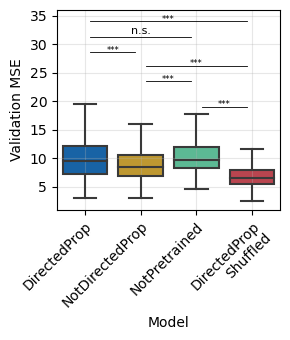

In [42]:
validation_loss = pickle.load(open(f'revisions_data/epoch_best_validation_loss.pkl', 'rb'))
performance_boxplots(validation_loss,
                     RNN_model_dirs,
                     RNN_model_names,
                     palette,
                     "figures_revisions/Figure_2/boxplots",
                     epoch="best",
                     set='Validation',
                     ylim=36,
                     y_offset_fixed=5,
                     y_offset_scale=0.09)

# Hold-out Test Dataset

In [51]:
dataset_path = f"{config.project_dir}/NI_maze/test/training"
test_loader = get_next_frame_dataloader(dataset_path, batch_size=1)

palette = {model: design['color'] for model, design in zip(RNN_model_dirs, RNN_model_designs)}

Loading file 1 of 500...
Loading file 101 of 500...
Loading file 201 of 500...
Loading file 301 of 500...
Loading file 401 of 500...
Dataset with 500 samples loaded.


In [52]:
test_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 0, test_loader)
pickle.dump(test_loss, open(f'revisions_data/epoch_0_test_loss.pkl', 'wb'))

Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [07:40<00:00, 76.69s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [07:46<00:00, 93.32s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [07:37<00:00, 76.18s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [07:54<00:00, 94.91s/it] 


Pretrained_Directional vs Pretrained_Godfrey: 3.0056342220471276e-57
Pretrained_Directional vs No_Pretraining: 0.0
Pretrained_Directional vs Shuffled_Directional: 1.0951468577343789e-298
Pretrained_Godfrey vs No_Pretraining: 0.0
Pretrained_Godfrey vs Shuffled_Directional: 1.6691489395749691e-286
No_Pretraining vs Shuffled_Directional: 2.126118900306972e-161


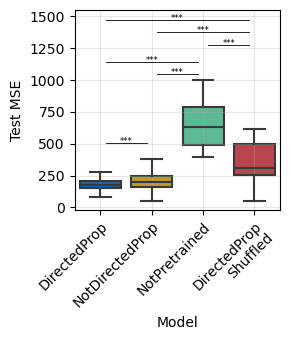

In [58]:
test_loss = pickle.load(open(f'revisions_data/epoch_0_test_loss.pkl', 'rb'))
performance_boxplots(test_loss,
                     RNN_model_dirs,
                     RNN_model_names,
                     palette,
                     "figures_revisions/Figure_2/boxplots",
                     epoch=0,
                     set='Test',
                     ylim=1550,
                     y_offset_fixed=50,
                     y_offset_scale=0.08)

In [54]:
test_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 1, test_loader)
pickle.dump(test_loss, open(f'revisions_data/epoch_1_test_loss.pkl', 'wb'))

Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [07:10<00:00, 71.73s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [07:12<00:00, 86.56s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [08:16<00:00, 82.79s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [13:26<00:00, 161.35s/it]


Pretrained_Directional vs Pretrained_Godfrey: 2.2194327375059008e-120
Pretrained_Directional vs No_Pretraining: 0.0
Pretrained_Directional vs Shuffled_Directional: 0.0
Pretrained_Godfrey vs No_Pretraining: 0.0
Pretrained_Godfrey vs Shuffled_Directional: 0.0
No_Pretraining vs Shuffled_Directional: 5.1440128829180676e-107


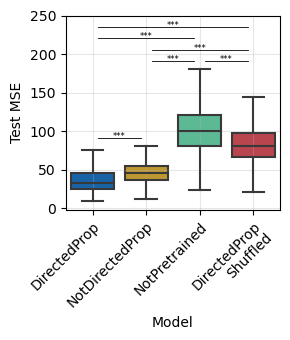

In [71]:
test_loss = pickle.load(open(f'revisions_data/epoch_1_test_loss.pkl', 'rb'))
performance_boxplots(test_loss,
                     RNN_model_dirs,
                     RNN_model_names,
                     palette,
                     "figures_revisions/Figure_2/boxplots",
                     epoch=1,
                     set='Test',
                     ylim=250,
                     y_offset_fixed=40,
                     y_offset_scale=0.15)

In [56]:
test_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, "best", test_loader)
pickle.dump(test_loss, open(f'revisions_data/epoch_best_test_loss.pkl', 'wb'))

Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [20:57<00:00, 209.55s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [07:43<00:00, 92.73s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [07:47<00:00, 77.87s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [08:02<00:00, 96.48s/it]


Pretrained_Directional vs Pretrained_Godfrey: 2.8108273275306228e-21
Pretrained_Directional vs No_Pretraining: 0.016867942855064783
Pretrained_Directional vs Shuffled_Directional: 2.212411680460279e-189
Pretrained_Godfrey vs No_Pretraining: 4.2421029995913314e-51
Pretrained_Godfrey vs Shuffled_Directional: 1.8448960655923741e-152
No_Pretraining vs Shuffled_Directional: 1.2e-322


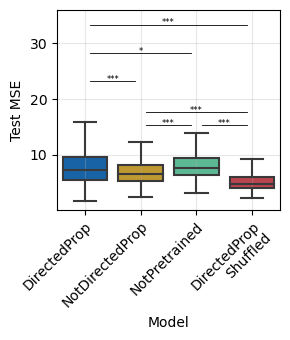

In [98]:
test_loss = pickle.load(open(f'revisions_data/epoch_best_test_loss.pkl', 'rb'))
performance_boxplots(test_loss,
                     RNN_model_dirs,
                     RNN_model_names,
                     palette,
                     "figures_revisions/Figure_2/boxplots",
                     epoch="best",
                     set='Test',
                     ylim=36,
                     y_offset_fixed=12,
                     y_offset_scale=0.17)